# AIoT Project

## Imports

In [1]:
import os

# basic data engineering
import pandas as pd
import numpy as np
import scipy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# db
import pymongo

# configs & other
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time

from psynlig import pca_explained_variance_bar

# utils processing
from utilsF import sliding_window_pd
from utilsF import apply_filter
from utilsF import filter_instances
from utilsF import flatten_instances_df
from utilsF import df_rebase
from utilsF import rename_df_column_values

# utils visualization
from utils_visualF import plot_instance_time_domain
from utils_visualF import plot_instance_3d
from utils_visualF import plot_np_instance
from utils_visualF import plot_heatmap
from utils_visualF import plot_scatter_pca

#ai Modeling
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler  # To scale the data, if not already scaled
import matplotlib.pyplot as plt


Start time of execution

In [2]:
time_start = time()

## Load configuration

In [3]:
config_path = os.path.join(os.getcwd(), "config.yml")

with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
client = pymongo.MongoClient(config["client"])

In [5]:
db = client[config["db"]]
collection = db[config["col"]]

In [6]:
found_keys = collection.distinct("label")
print("Existing DB keys:", found_keys)

Existing DB keys: ['data_A_01', 'data_A_02', 'data_A_03', 'data_A_04', 'data_A_05', 'data_A_06', 'data_A_07', 'data_A_08', 'data_A_09', 'data_B_01', 'data_B_02', 'data_B_03', 'data_B_04', 'data_B_05', 'data_B_06', 'data_B_07', 'data_B_08', 'data_B_09']


## EDA task 1: Barplot with time-length per class

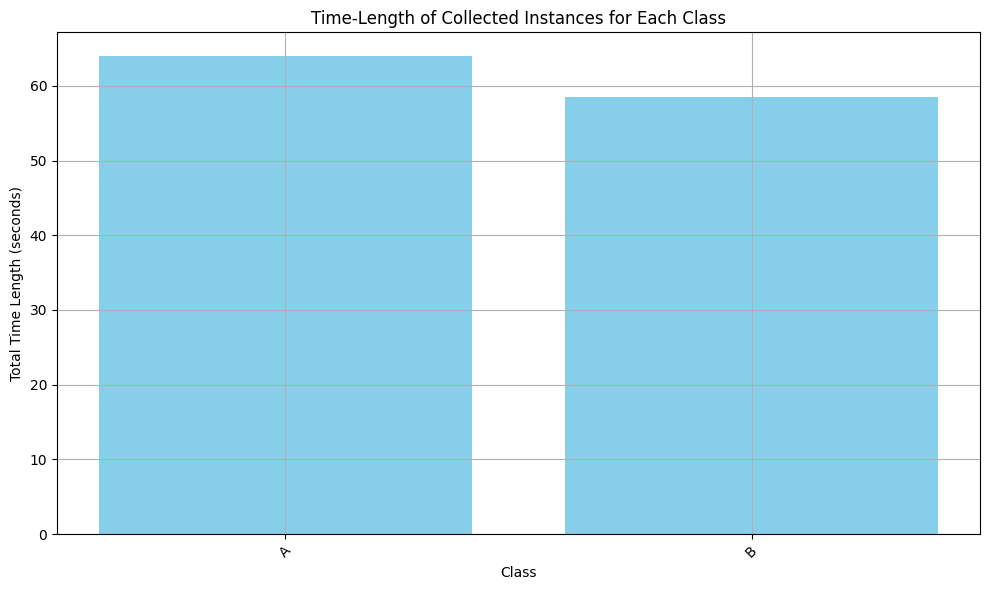

In [7]:
def load_config(config_path='config.yml'):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def connect_mongodb(config):
    client = pymongo.MongoClient(config['client'])
    db = client[config['db']]
    return db[config['col']]

def fetch_and_process_data(collection):
    try:
        # Fetch data from MongoDB
        data = list(collection.find({}, {'_id': 0, 'label': 1, 'datetime': 1}))
        df = pd.DataFrame(data)
        
        # Explode the datetime array so each timestamp is a separate row
        df = df.explode('datetime')
        
        # Convert the datetime field to proper datetime objects
        df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
        
        # Filter out any rows with invalid datetime
        df = df.dropna(subset=['datetime'])
        
        # Sort by datetime to ensure proper calculation of time differences
        df.sort_values(by=['label', 'datetime'], inplace=True)
        
        # Calculate the time differences between consecutive timestamps
        df['time_length'] = df.groupby('label')['datetime'].diff().dt.total_seconds().fillna(0)
        
        # Extract the main class (e.g., 'A' or 'B') from the label
        df['class'] = df['label'].apply(lambda x: x.split('_')[1][0])
        
        # Group by the main class and sum the time lengths
        result_df = df.groupby('class')['time_length'].sum().reset_index()
        
        return result_df
    except Exception as e:
        print(f"An error occurred while fetching or converting data: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

def plot_data(result_df):
    if not result_df.empty:
        plt.figure(figsize=(10, 6))
        plt.bar(result_df['class'], result_df['time_length'], color='skyblue')
        plt.xlabel('Class')
        plt.ylabel('Total Time Length (seconds)')
        plt.title('Time-Length of Collected Instances for Each Class')
        plt.grid(True)  # Optional: add grid for better readability
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No data to plot.")

def main():
    config = load_config()  # Adjust this path to your actual configuration file
    collection = connect_mongodb(config)
    result_df = fetch_and_process_data(collection)
    plot_data(result_df)

if __name__ == "__main__":
    main()


## EDA Task 2-3: Windowing and the after barplot

Data frame structure before windowing:
      acc_x     acc_y     acc_z      label                datetime
0 -0.103638 -0.001953  0.748901  data_A_01 2024-05-23 18:18:28.129
1 -0.083374  0.009277  0.751831  data_A_01 2024-05-23 18:18:28.159
2 -0.090088  0.004883  0.713379  data_A_01 2024-05-23 18:18:28.159
3 -0.162109  0.020264  0.657227  data_A_01 2024-05-23 18:18:28.188
4 -0.191895  0.054688  0.646362  data_A_01 2024-05-23 18:18:28.219
Total number of rows: 6063
Number of windows: 865
Sample data from the first window:
      acc_x     acc_y     acc_z      label                datetime
2 -0.090088  0.004883  0.713379  data_A_01 2024-05-23 18:18:28.159
3 -0.162109  0.020264  0.657227  data_A_01 2024-05-23 18:18:28.188
4 -0.191895  0.054688  0.646362  data_A_01 2024-05-23 18:18:28.219
5 -0.152588  0.067993  0.671387  data_A_01 2024-05-23 18:18:28.219
6 -0.107788  0.066406  0.670654  data_A_01 2024-05-23 18:18:28.249


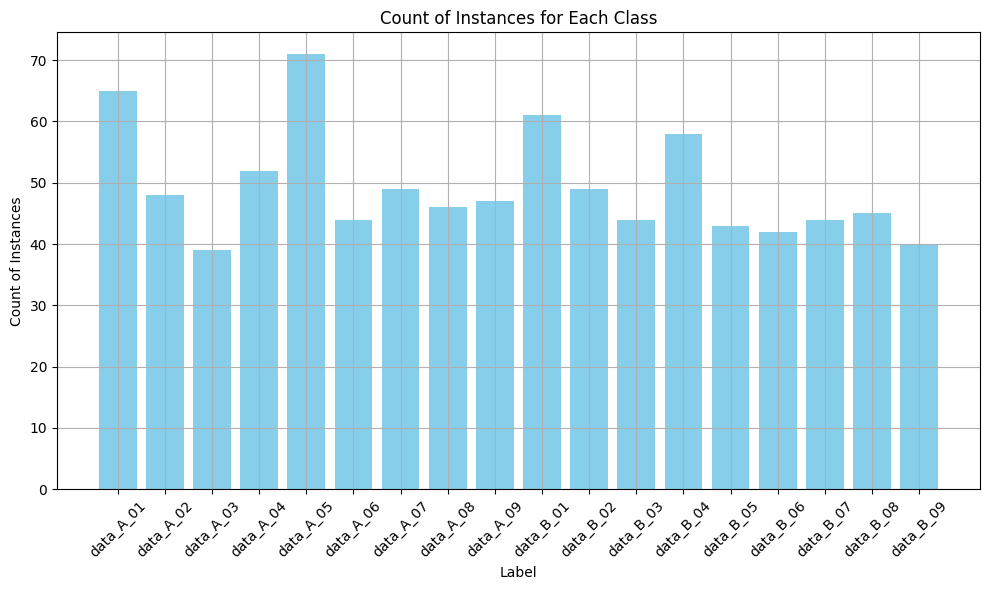

In [8]:
# Load configuration
def load_config(config_path='config.yml'):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Connect to MongoDB
def connect_mongodb(config):
    client = pymongo.MongoClient(config['client'])
    db = client[config['db']]
    return db[config['col']]

# Fetch data from MongoDB
def fetch_data(collection):
    data = list(collection.find({}, {'_id': 0, 'label': 1, 'data': 1, 'datetime': 1}))
    return data

# Convert fetched data to DataFrame
def prepare_dataframe(data):
    records = []
    for record in data:
        acc_x = record['data']['acc_x']
        acc_y = record['data']['acc_y']
        acc_z = record['data']['acc_z']
        label = record['label']
        for i in range(len(acc_x)):
            records.append([acc_x[i], acc_y[i], acc_z[i], label, record['datetime'][i]])
    df = pd.DataFrame(records, columns=['acc_x', 'acc_y', 'acc_z', 'label', 'datetime'])
    return df

# Process Data
def process_data(df):
    sampling_rate = 50  # 50 Hz
    window_length_seconds = 0.2  # seconds
    overlap_percentage = 70  # percent

    window_size = round(sampling_rate * window_length_seconds)  # Number of samples in the window
    overlap = int(window_size * (overlap_percentage / 100))  # Overlap in number of samples

    # Flattening arrays and preparing DataFrame
    if 'acc_x' in df.columns and 'acc_y' in df.columns and 'acc_z' in df.columns:
        df = df.apply(pd.Series.explode).reset_index(drop=True)

    # Debugging output
    print("Data frame structure before windowing:")
    print(df.head())
    print("Total number of rows:", len(df))

    # Applying sliding window
    windows_list = sliding_window_pd(df, ws=window_size, overlap=overlap, w_type='hann', w_center=True)

    # Output the results
    print("Number of windows:", len(windows_list))
    if windows_list:
        print("Sample data from the first window:")
        print(windows_list[0].head())  # Display first few rows of the first window

    return windows_list

# Count instances for each class
def count_instances(windows_list):
    label_counts = {}
    for window in windows_list:
        labels = window['label'].unique()
        for label in labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
    return label_counts

# Plot the count of instances
def plot_instance_counts(label_counts):
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('Count of Instances')
    plt.title('Count of Instances for Each Class')
    plt.grid(True)  # Optional: add grid for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main function
def main():
    config = load_config()  # Adjust this path to your actual configuration file
    collection = connect_mongodb(config)
    data = fetch_data(collection)
    df = prepare_dataframe(data)
    windows_list = process_data(df)
    label_counts = count_instances(windows_list)
    plot_instance_counts(label_counts)

if __name__ == "__main__":
    main()


## EDA Task 4-6: Filtering and visualization

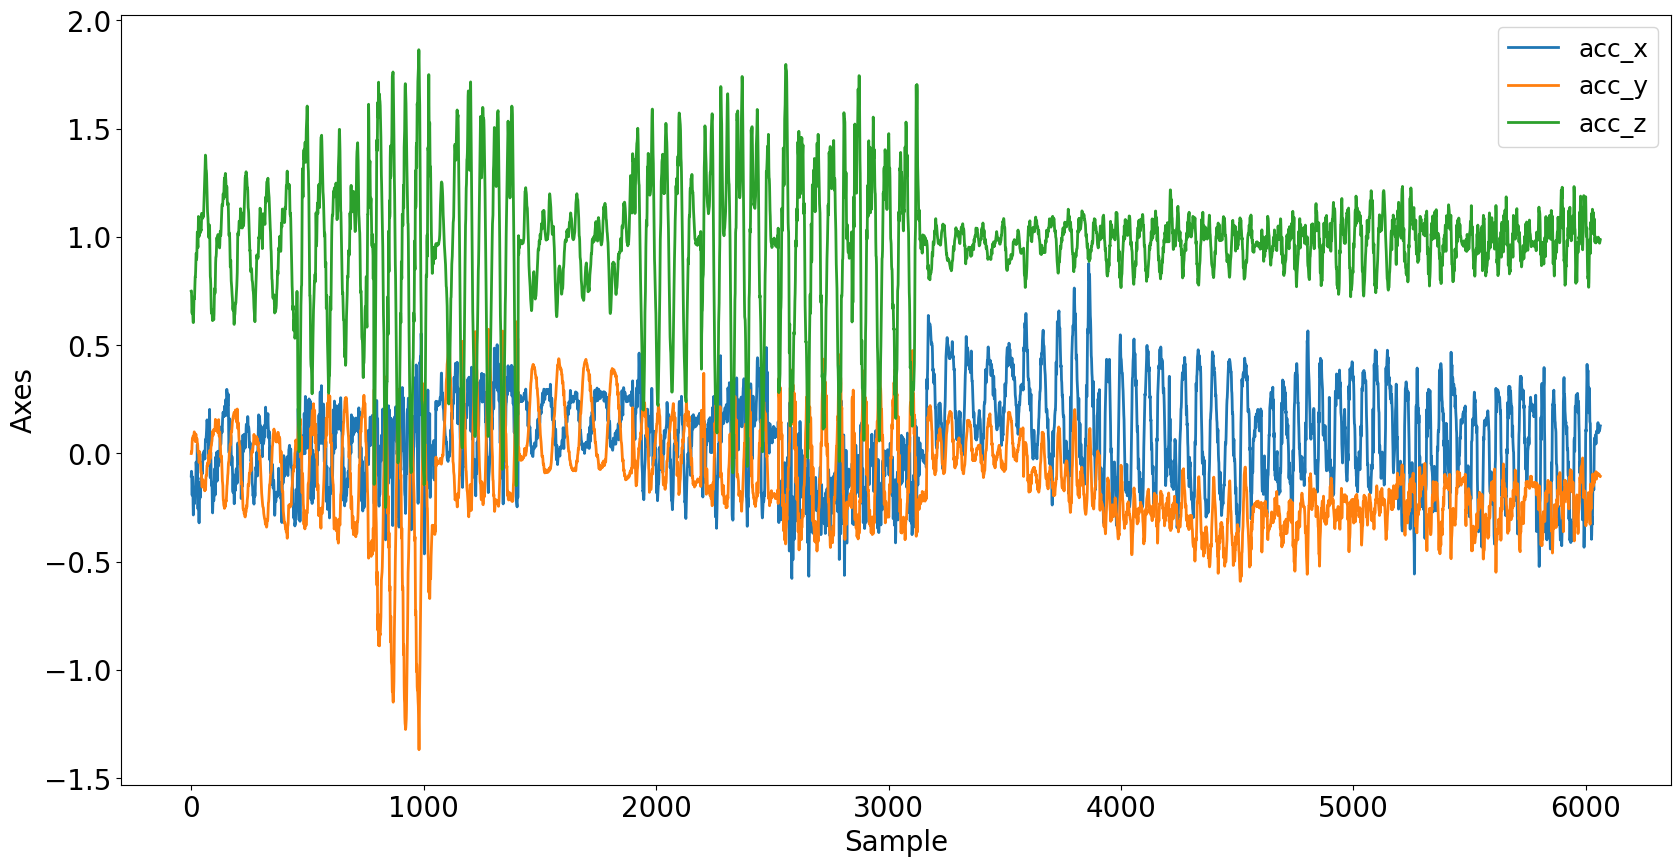

In [9]:
def load_config(config_path='config.yml'):
    """Load configuration from the YAML file."""
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def connect_mongodb(config):
    """Connect to MongoDB using the loaded configuration."""
    client = pymongo.MongoClient(config['client'])
    return client[config['db']][config['col']]

def fetch_data(collection):
    """Fetch data from MongoDB collection."""
    return list(collection.find({}, {'_id': 0, 'label': 1, 'data': 1, 'datetime': 1}))

def prepare_dataframe(data):
    """Convert fetched data to DataFrame."""
    records = []
    for record in data:
        acc_x = record['data']['acc_x']
        acc_y = record['data']['acc_y']
        acc_z = record['data']['acc_z']
        datetime = record['datetime']
        label = record['label']
        for x, y, z, dt in zip(acc_x, acc_y, acc_z, datetime):
            records.append([x, y, z, label, dt])
    return pd.DataFrame(records, columns=['acc_x', 'acc_y', 'acc_z', 'label', 'datetime'])

def filter_data(df):
    """Apply low-pass filter to accelerometer data."""
    order = 5  # Filter order
    wn = 0.8  # Cutoff frequency as a fraction of the Nyquist rate (0.5 * sample_rate)
    filter_type = 'lowpass'
    # Filter each accelerometer data column
    return df.apply(lambda col: apply_filter(col, order=order, wn=wn, filter_type=filter_type) if col.name in ['acc_x', 'acc_y', 'acc_z'] else col)

def main():
    config = load_config()
    collection = connect_mongodb(config)
    data = fetch_data(collection)
    df = prepare_dataframe(data)
    filtered_data = filter_data(df)
    # Optionally, visualize the filtered data using a time domain plot
    plot_instance_time_domain(filtered_data[['acc_x', 'acc_y', 'acc_z']])
    plt.show()

if __name__ == "__main__":
    main()


## General data preparations to grasp the idea

In [10]:
def load_config(config_path='config.yml'):
    """Load configuration from the YAML file."""
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def connect_mongodb(config):
    """Connect to MongoDB using the loaded configuration."""
    client = pymongo.MongoClient(config['client'])
    return client[config['db']][config['col']]

# Fetch data from MongoDB and return as a list of dictionaries
def fetch_data(collection):
    data = list(collection.find({}, {'_id': 0, 'label': 1, 'data': 1, 'datetime': 1}))
    return data

# Convert fetched data to DataFrame and generate labels
def prepare_dataframe(data):
    records = []
    labels = []  # List to hold labels
    for record in data:
        acc_x = record['data']['acc_x']
        acc_y = record['data']['acc_y']
        acc_z = record['data']['acc_z']
        for i in range(len(acc_x)):
            records.append([acc_x[i], acc_y[i], acc_z[i]])
            # Classify based on the presence of 'A' or 'B' in the label
            if 'A' in record['label']:
                labels.append('vertical')
            elif 'B' in record['label']:
                labels.append('horizontal')
    df = pd.DataFrame(records, columns=['acc_x', 'acc_y', 'acc_z'])
    return df, labels

# Process data (potentially for scaling or other transformations)
def process_data(df):
    # Placeholder for any data processing like scaling
    return df

# Main function to orchestrate the workflow
def main():
    config = load_config()
    collection = connect_mongodb(config)
    data = fetch_data(collection)
    df, labels = prepare_dataframe(data)
    
    X = process_data(df)  # Process the DataFrame to get the final feature matrix X
    y = np.array(labels)  # Convert labels list to a numpy array

    # Perform the train/test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

    # Optionally, print the shapes of the outputs to confirm the split
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)
    print("Head of y_train:", y_train[:10])
if __name__ == "__main__":
    main()


X_train shape: (4850, 3)
X_test shape: (1213, 3)
y_train shape: (4850,)
y_test shape: (1213,)
Head of y_train: ['vertical' 'horizontal' 'horizontal' 'horizontal' 'vertical' 'vertical'
 'vertical' 'horizontal' 'horizontal' 'horizontal']


## Transform the list of DataFrames to NumPy array

Transform the list of DataFrames to NumPy array that contains the windows: (instances, x, y)

In [11]:
# Load configuration, connect to MongoDB, fetch data, and all related functions
def load_config(config_path='config.yml'):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def connect_mongodb(config):
    client = pymongo.MongoClient(config['client'])
    db = client[config['db']]
    return db[config['col']]

def fetch_data(collection):
    data = list(collection.find({}, {'_id': 0, 'label': 1, 'data': 1, 'datetime': 1}))
    return data

def prepare_dataframe(data):
    records = []
    for record in data:
        acc_x = record['data']['acc_x']
        acc_y = record['data']['acc_y']
        acc_z = record['data']['acc_z']
        label = record['label']
        for i in range(len(acc_x)):
            records.append([acc_x[i], acc_y[i], acc_z[i], label, record['datetime'][i]])
    return pd.DataFrame(records, columns=['acc_x', 'acc_y', 'acc_z', 'label', 'datetime'])

def process_data(df):
    sampling_rate = 50
    window_length_seconds = 0.2
    overlap_percentage = 70

    window_size = round(sampling_rate * window_length_seconds)
    overlap = int(window_size * (overlap_percentage / 100))

    windows_list = sliding_window_pd(df, ws=window_size, overlap=overlap, w_type='hann', w_center=True)
    return np.array([window.to_numpy() for window in windows_list])


In [12]:
config = load_config()
collection = connect_mongodb(config)
data = fetch_data(collection)
df = prepare_dataframe(data)
final_data_array = process_data(df)
print("Shape of data:", final_data_array.shape)

Shape of data: (865, 10, 5)


## More specified data preparation for SVM type

In [13]:
def fetch_data(collection):
    """Fetch data from MongoDB and return as a list of dictionaries."""
    return list(collection.find({}, {'_id': 0, 'label': 1, 'data': 1, 'datetime': 1}))

def prepare_dataframe(data, window_size):
    """Convert fetched data to DataFrame and correctly assign labels for each data window."""
    records = []
    labels = []  # List to hold labels for each window

    for record in data:
        acc_x = record['data']['acc_x']
        acc_y = record['data']['acc_y']
        acc_z = record['data']['acc_z']
        label = 'vertical' if 'A' in record['label'] else 'horizontal'

        # Calculate how many full windows can be formed from the available data points
        num_windows = len(acc_x) // window_size

        for i in range(num_windows):
            start = i * window_size
            end = start + window_size
            window_data = []
            window_data.extend(acc_x[start:end])
            window_data.extend(acc_y[start:end])
            window_data.extend(acc_z[start:end])
            records.append(window_data)
            labels.append(label)  # Append the same label for each full window

    df = pd.DataFrame(records)
    return df, labels

window_size = 10  # Define window size
df, labels = prepare_dataframe(data, window_size)

In [14]:
def process_data(df):
    return df.to_numpy()


final_data_array = process_data(df)
flattened_data = final_data_array.reshape(final_data_array.shape[0], -1)
print("Shape of data:", final_data_array.shape)
print("Shape of flattened data:", flattened_data.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(flattened_data, np.array(labels), test_size=0.20, shuffle=True, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Head of y_train:", y_train[:10])

Shape of data: (597, 30)
Shape of flattened data: (597, 30)
X_train shape: (477, 30)
X_test shape: (120, 30)
y_train shape: (477,)
y_test shape: (120,)
Head of y_train: ['vertical' 'horizontal' 'vertical' 'vertical' 'horizontal' 'vertical'
 'horizontal' 'horizontal' 'horizontal' 'vertical']


## Scaling & Dimensionality Reduction with PCA using the 1D (flattened) data

In [15]:

# Standardizing the data is generally recommended before performing PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Original number of features:", X_train_scaled.shape[1])
print("Reduced number of features:", X_train_pca.shape[1])


Original number of features: 30
Reduced number of features: 5


### SVM and performance report

In [16]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
    'kernel': ['rbf', 'poly', 'sigmoid']  # Type of kernel
}

# Create a Support Vector Classifier
svc = SVC()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

Confusion Matrix


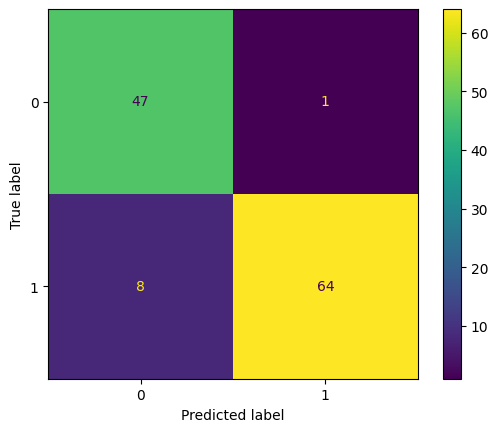

              precision    recall  f1-score   support

  horizontal       0.85      0.98      0.91        48
    vertical       0.98      0.89      0.93        72

    accuracy                           0.93       120
   macro avg       0.92      0.93      0.92       120
weighted avg       0.93      0.93      0.93       120



In [17]:
# Predictions on the test set
y_pred = grid_search.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print("Confusion Matrix")
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred))

In [18]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.94
